# setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import io
from scipy.stats import pearsonr

/home/josegfer/miniconda3/envs/lusiadas/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

# data

In [3]:
H_train = torch.load('data/H_train.pt')
y_train = torch.load('data/y_train.pt')

H_test = torch.load('data/H_test.pt')
y_test = torch.load('data/y_test.pt')

In [4]:
H_train.shape, H_test.shape

(torch.Size([50000, 512]), torch.Size([10000, 512]))

# dataset

In [5]:
class csv(Dataset):
  def __init__(self, X):
    super().__init__()
    self.X = torch.Tensor(X)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx, :]

def repair(ds, batch_size, collate):
  return DataLoader(ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)

# model

In [6]:
class mlp_model(nn.Module):
  def __init__(self, d = 512, p = 2):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(in_features = d, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features = 64),
        nn.ReLU(),
        nn.Linear(in_features = 64, out_features = 16),
        nn.ReLU(),
        nn.Linear(in_features = 16, out_features = p),
    )

  def forward(self, X):
    latent = self.encoder(X)
    return latent

# utils

In [7]:
def train(model, loader, criterion, optimizer):
  model.train()
  cost = 0
  for x, d in loader:
    x, d = x.to(DEVICE), d.to(DEVICE)
    btsz = len(x) // 2
    h = model.forward(x)
    dhat = F.pairwise_distance(h[:btsz], h[btsz:])**2
    loss = criterion(dhat, d)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    cost += loss.item()
  return cost / loader.dataset.__len__()

In [8]:
def eval(model, loader, criterion, synthesis = True):
  if synthesis:
    D = torch.empty(size = [0])
    Dhat = torch.empty(size = [0])
    H = torch.empty(size = [0])

  model.eval()
  cost = 0
  with torch.no_grad():
    for x, d in (loader):
      x, d = x.to(DEVICE), d.to(DEVICE)
      btsz = len(x) // 2
      h = model.forward(x)
      dhat = F.pairwise_distance(h[:btsz], h[btsz:])**2
      loss = criterion(dhat, d)
      cost += loss.item()

      if synthesis:
        D = torch.cat((D, d.detach().cpu()))
        Dhat = torch.cat((Dhat, dhat.detach().cpu()))
        H = torch.cat((H, h.detach().cpu()))

  if synthesis:
    return D, Dhat, H, cost / loader.dataset.__len__()
  return cost / loader.dataset.__len__()

# p = 2

In [9]:
batch_size = 256
epochs = 100

In [10]:
train_ds = csv(H_test)

def pair_collate(batch, p = 2):
  btsz = len(batch) // 2
  x = torch.stack(batch)
  x_i = x[:btsz]
  x_j = x[btsz:]
  distance = F.pairwise_distance(x_i, x_j, p = p)**p
  return x, distance

collate = pair_collate
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)

In [11]:
model = mlp_model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-3)
criterion = nn.MSELoss()

In [12]:
log = []
for epoch in tqdm(range(epochs)):
  log.append(train(model, train_loader, criterion, optimizer))
  train_loader = repair(train_ds, batch_size, collate)

100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


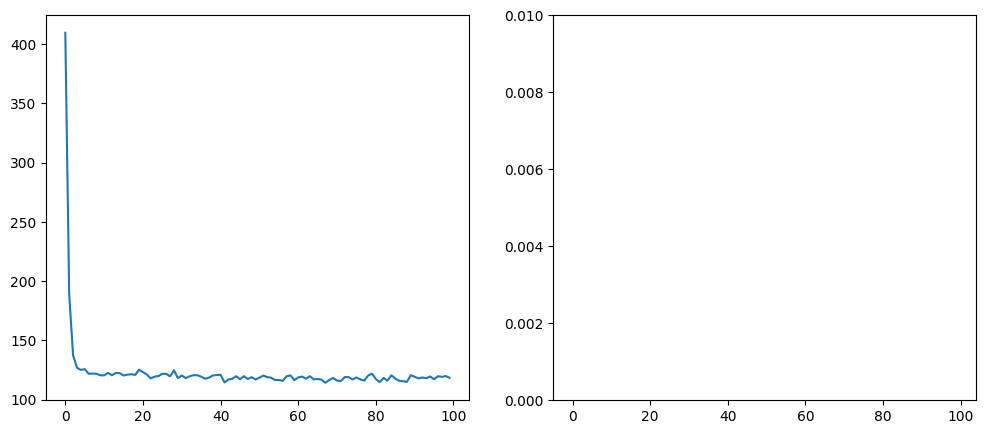

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(log);
axes[1].plot(log);
axes[1].set_ylim([0, 0.01]);

In [14]:
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)
Dtrain, Dtrainhat, Htrain, train_loss = eval(model, train_loader, criterion, synthesis = True)
train_loss, pearsonr(Dtrainhat, Dtrain)

(119.710840234375, PearsonRResult(statistic=0.6101169630368337, pvalue=0.0))

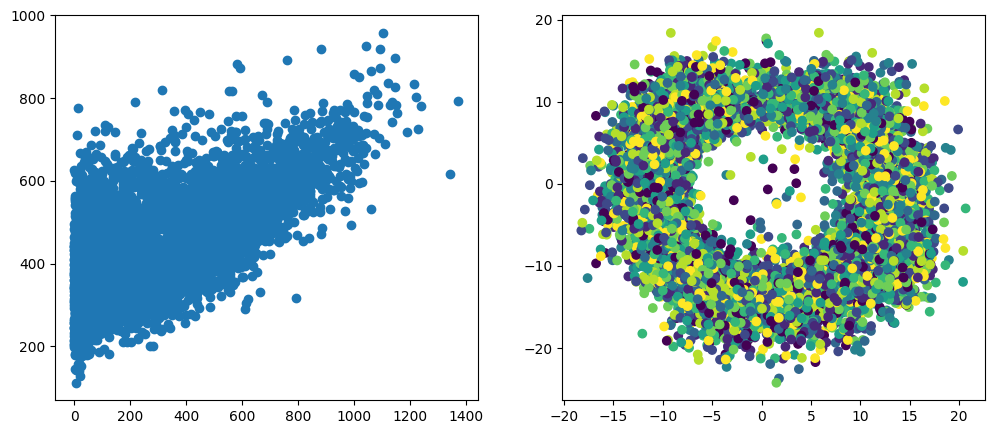

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(Dtrainhat, Dtrain);
axes[1].scatter(Htrain[:, 0], Htrain[:, 1], c = y_test);

# p = 4

In [16]:
batch_size = 256
epochs = 100

In [17]:
train_ds = csv(H_test)

def pair_collate(batch, p = 4):
  btsz = len(batch) // 2
  x = torch.stack(batch)
  x_i = x[:btsz]
  x_j = x[btsz:]
  distance = F.pairwise_distance(x_i, x_j, p = p)**p
  return x, distance

collate = pair_collate
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)

In [18]:
model = mlp_model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-3)
criterion = nn.MSELoss()

In [19]:
log = []
for epoch in tqdm(range(epochs)):
  log.append(train(model, train_loader, criterion, optimizer))
  train_loader = repair(train_ds, batch_size, collate)

  3%|▎         | 3/100 [00:00<00:11,  8.43it/s]

100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


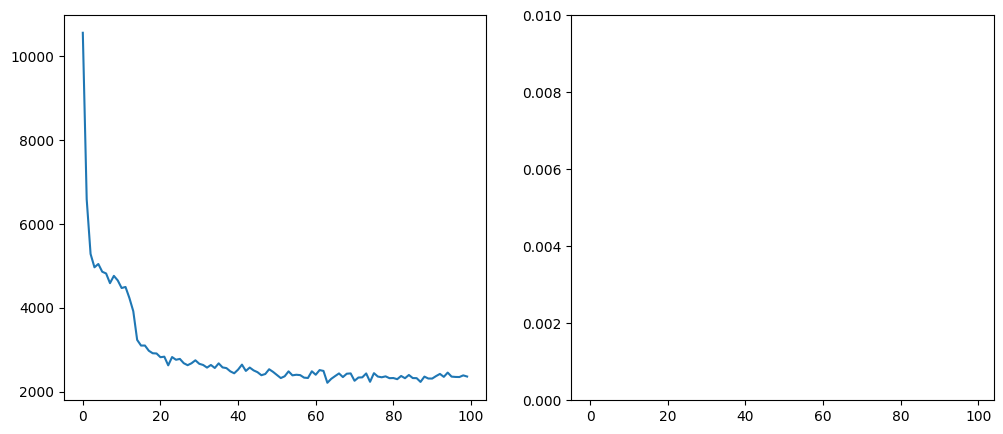

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(log);
axes[1].plot(log);
axes[1].set_ylim([0, 0.01]);

In [21]:
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)
Dtrain, Dtrainhat, Htrain, train_loss = eval(model, train_loader, criterion, synthesis = True)
train_loss, pearsonr(Dtrainhat, Dtrain)

(2305.88095625, PearsonRResult(statistic=0.7307738307662914, pvalue=0.0))

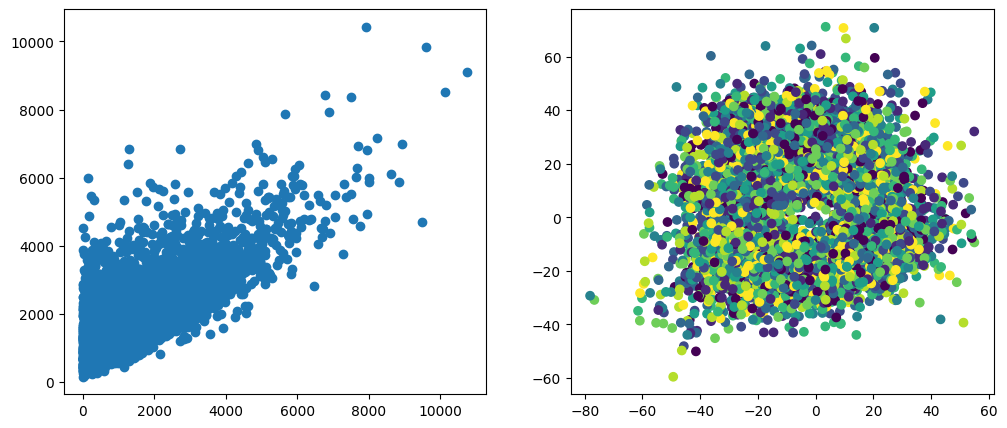

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(Dtrainhat, Dtrain);
axes[1].scatter(Htrain[:, 0], Htrain[:, 1], c = y_test);

# p = 8

In [23]:
batch_size = 256
epochs = 100

In [24]:
train_ds = csv(H_test)

def pair_collate(batch, p = 8):
  btsz = len(batch) // 2
  x = torch.stack(batch)
  x_i = x[:btsz]
  x_j = x[btsz:]
  distance = F.pairwise_distance(x_i, x_j, p = p)**p
  return x, distance

collate = pair_collate
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)

In [25]:
model = mlp_model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-3)
criterion = nn.MSELoss()

In [26]:
log = []
for epoch in tqdm(range(epochs)):
  log.append(train(model, train_loader, criterion, optimizer))
  train_loader = repair(train_ds, batch_size, collate)

  3%|▎         | 3/100 [00:00<00:09, 10.49it/s]

100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


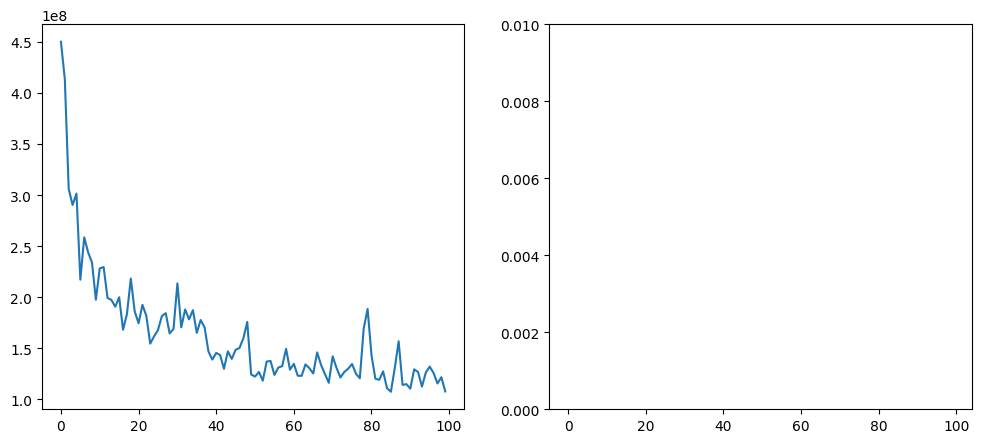

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(log);
axes[1].plot(log);
axes[1].set_ylim([0, 0.01]);

In [28]:
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)
Dtrain, Dtrainhat, Htrain, train_loss = eval(model, train_loader, criterion, synthesis = True)
train_loss, pearsonr(Dtrainhat, Dtrain)

(98858691.584, PearsonRResult(statistic=0.8306102755503283, pvalue=0.0))

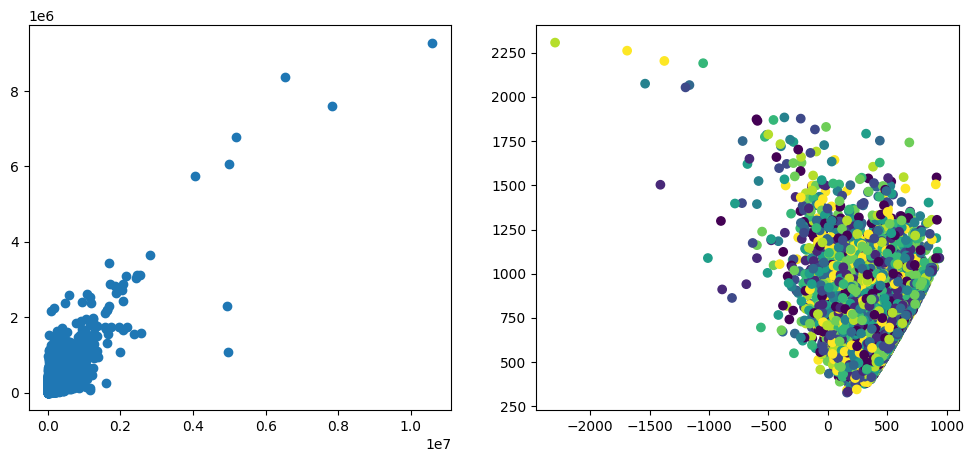

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(Dtrainhat, Dtrain);
axes[1].scatter(Htrain[:, 0], Htrain[:, 1], c = y_test);

# p = 16

In [32]:
batch_size = 256
epochs = 100

In [33]:
train_ds = csv(H_test)

def pair_collate(batch, p = 16):
  btsz = len(batch) // 2
  x = torch.stack(batch)
  x_i = x[:btsz]
  x_j = x[btsz:]
  distance = F.pairwise_distance(x_i, x_j, p = p)**p
  return x, distance

collate = pair_collate
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)

In [34]:
model = mlp_model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-3)
criterion = nn.MSELoss()

In [35]:
log = []
for epoch in tqdm(range(epochs)):
  log.append(train(model, train_loader, criterion, optimizer))
  train_loader = repair(train_ds, batch_size, collate)

  3%|▎         | 3/100 [00:00<00:09, 10.02it/s]

100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


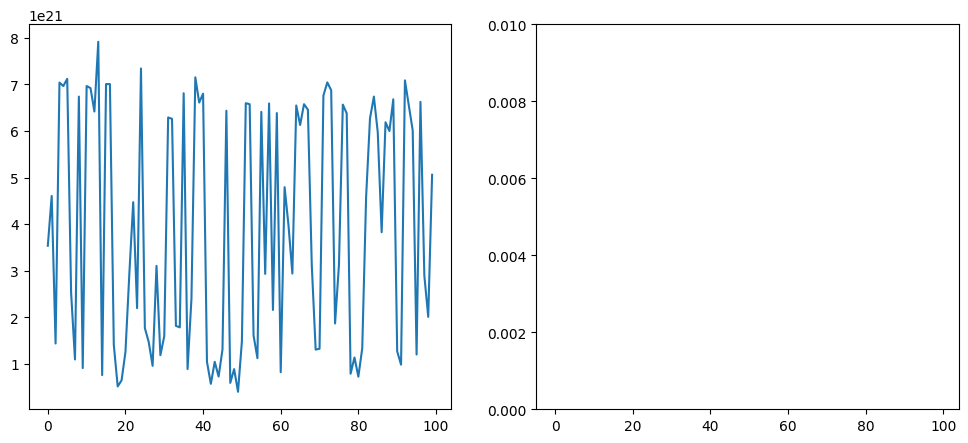

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(log);
axes[1].plot(log);
axes[1].set_ylim([0, 0.01]);

In [37]:
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)
Dtrain, Dtrainhat, Htrain, train_loss = eval(model, train_loader, criterion, synthesis = True)
train_loss, pearsonr(Dtrainhat, Dtrain)

(6.820283582712166e+21,
 PearsonRResult(statistic=0.284567508383048, pvalue=8.871783846230189e-94))

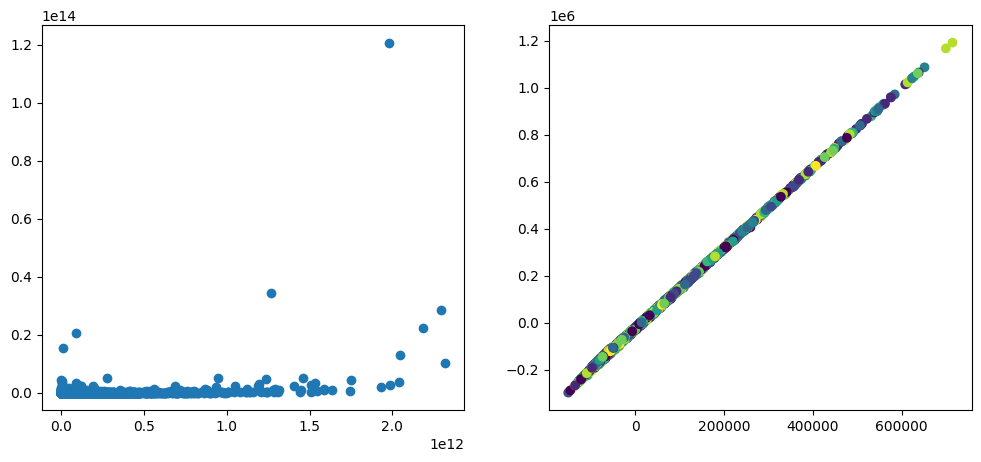

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(Dtrainhat, Dtrain);
axes[1].scatter(Htrain[:, 0], Htrain[:, 1], c = y_test);

# p = 32

In [39]:
batch_size = 256
epochs = 100

In [40]:
train_ds = csv(H_test)

def pair_collate(batch, p = 32):
  btsz = len(batch) // 2
  x = torch.stack(batch)
  x_i = x[:btsz]
  x_j = x[btsz:]
  distance = F.pairwise_distance(x_i, x_j, p = p)**p
  return x, distance

collate = pair_collate
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)

In [41]:
model = mlp_model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-3)
criterion = nn.MSELoss()

In [42]:
log = []
for epoch in tqdm(range(epochs)):
  log.append(train(model, train_loader, criterion, optimizer))
  train_loader = repair(train_ds, batch_size, collate)

  1%|          | 1/100 [00:00<00:10,  9.90it/s]

100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


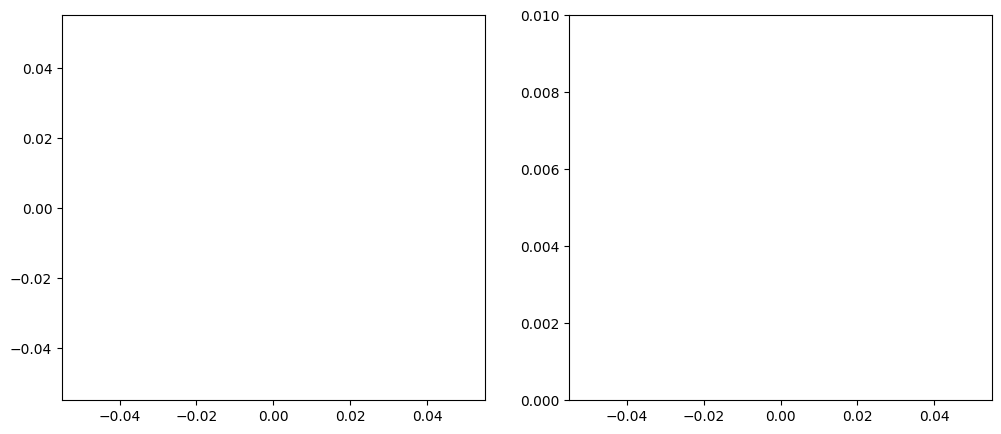

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(log);
axes[1].plot(log);
axes[1].set_ylim([0, 0.01]);

In [44]:
train_loader = DataLoader(train_ds, batch_size = 2 * batch_size, shuffle = True, collate_fn = collate)
Dtrain, Dtrainhat, Htrain, train_loss = eval(model, train_loader, criterion, synthesis = True)
train_loss, pearsonr(Dtrainhat, Dtrain)

(inf,
 PearsonRResult(statistic=0.005802419664293541, pvalue=0.6816637175909075))

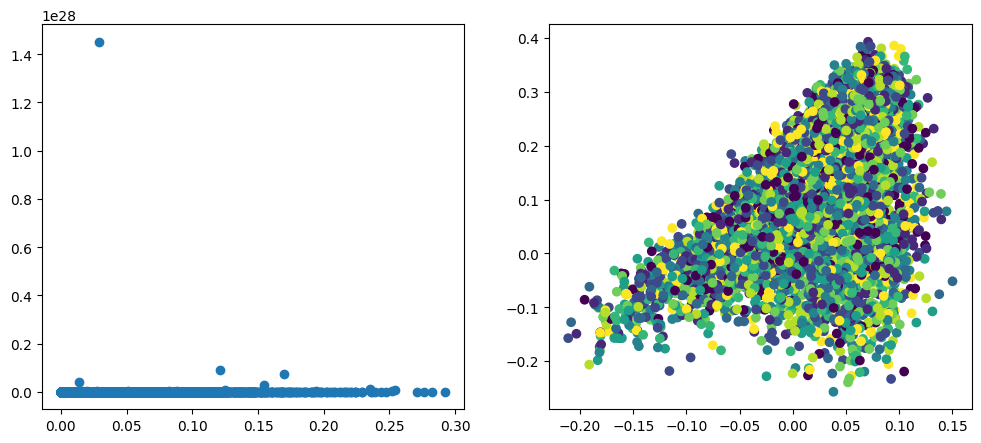

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(Dtrainhat, Dtrain);
axes[1].scatter(Htrain[:, 0], Htrain[:, 1], c = y_test);